In [2]:
!python --version

import logging
import sys

logging.basicConfig(
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.INFO)

Python 3.8.12


In [3]:
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/mnt/d/tmp/nu_scene/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.471 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


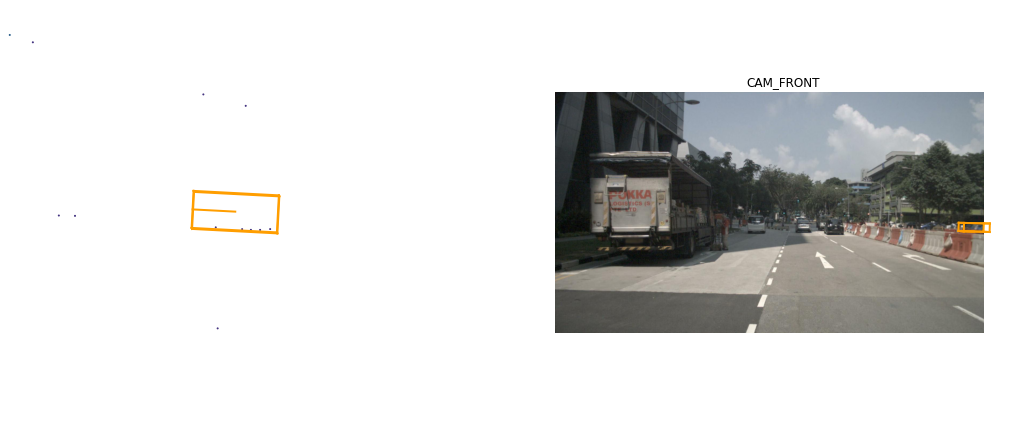

In [3]:
my_scene = nusc.scene[0]

my_sample = nusc.get('sample', my_scene['first_sample_token'])
nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])

my_annotation = nusc.get('sample_annotation', my_sample['anns'][2])
nusc.render_annotation(my_sample['anns'][2])

In [27]:
from matplotlib import pyplot as plt
import imageio

class MyUtils():
    NUSCENE_HOME = "/mnt/d/tmp/nu_scene/data/sets/nuscenes/"

    def __init__(self, nusc):
        self.nusc = nusc

    def get_img(sample_data):
        path_to_im = MyUtils.NUSCENE_HOME + sample_data['filename']
        im = imageio.imread(path_to_im)            
        return im

    def convert_bin_to_pcd(bin_path):
        
        return 0

    def get_multi(self, frames_num, scene):
        first = self.nusc.get('sample', scene['first_sample_token'])
        rs = []

        cur = first
        # print(f"{cur}")
        for _ in range(frames_num):
            cur_token = cur['data']['CAM_FRONT']
            cur_sample = nusc.get('sample_data', cur_token)

            rs.append(MyUtils.get_img(cur_sample))            

            next_token = cur['next']
            if (not next_token):
                logging.info(f"No more next sample, last={cur['token']}")
                break

            cur = self.nusc.get('sample', next_token)
            
        return rs        



my_util = MyUtils(nusc)
rs = my_util.get_multi(1000, nusc.scene[1])

nusc.get('sample', nusc.scene[0]['first_sample_token'])

nusc.get('sample', '39586f9d59004284a7114a68825e8eec')
nusc.get('sample_data', '94368c083c674f7a84c7273854bfc7ac')

# imageio.mimsave('./result.gif', rs)

INFO - 2021-10-18 15:14:57,145 - 3972912185 - No more next sample, last=281b92269fd648d4b52d06ac06ca6d65


{'token': '94368c083c674f7a84c7273854bfc7ac',
 'sample_token': '356d81f38dd9473ba590f39e266f54e5',
 'ego_pose_token': '94368c083c674f7a84c7273854bfc7ac',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402928247914,
 'fileformat': 'pcd',
 'is_key_frame': False,
 'height': 0,
 'width': 0,
 'filename': 'sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928247914.pcd.bin',
 'prev': '38f3e46f0845441295e639bc5a4e24ca',
 'next': '024b8e9233e4498abe30708c476b3bae',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

INFO - 2021-10-18 20:33:04,247 - 269279660 - token=9d9bf11fb0e144c8b446d54a8a00184f


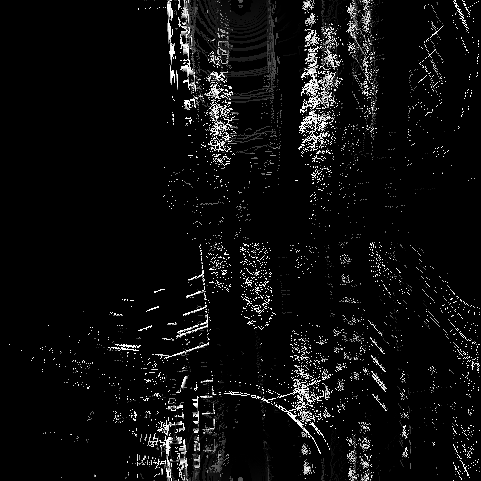

INFO - 2021-10-18 20:33:04,577 - 269279660 - token=4f792c8da81e4cb7aca1790654da1c27


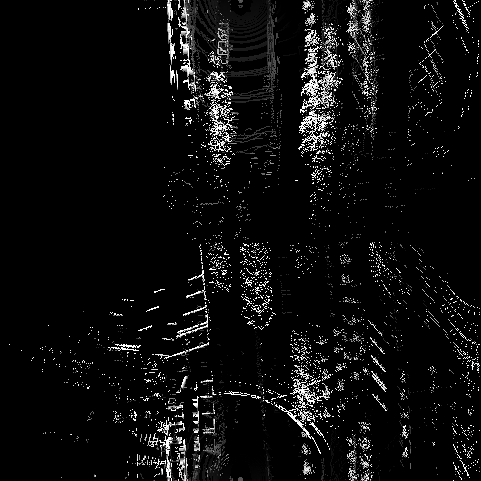

INFO - 2021-10-18 20:33:04,926 - 269279660 - token=28aaabeb212146a28a511858c09cf20c


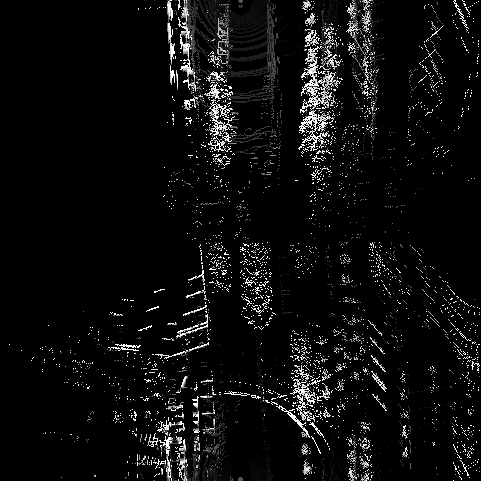

INFO - 2021-10-18 20:33:05,431 - 269279660 - token=c4f1a270736445e185379a80c29a5139


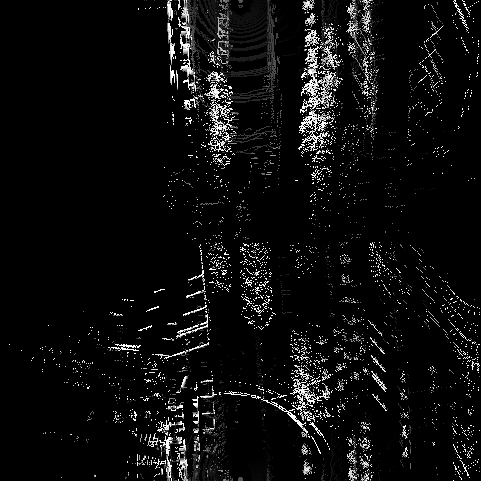

INFO - 2021-10-18 20:33:05,822 - 269279660 - token=6a97481174074729a9d0ffa096eaa498


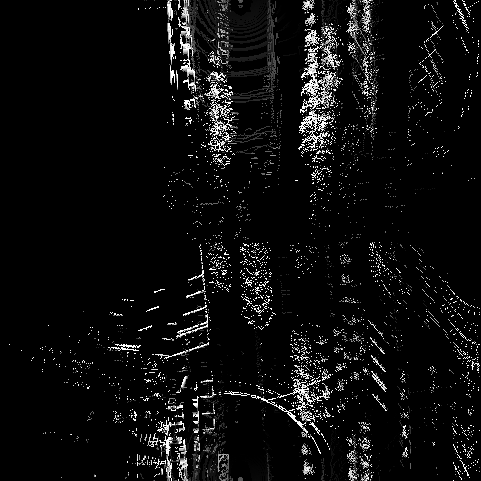

In [81]:
!export LIBGL_ALWAYS_INDIRECT=1


from PIL import Image
import imageio

from open3d import geometry, utility, visualization
from matplotlib import pyplot as plt
import struct
import numpy as np

class LiDAR_Visualizer():
    RANGE       = 120
    RIGHT_MOST  = RANGE/2
    LEFT_MOST   = -1 * RANGE/2

    BACK_MOST   = -RANGE/2
    FORE_MOST   = RANGE/2

    BOTT_MOST   = -2
    TOP_MOST    = 3

    side_range = (LEFT_MOST, RIGHT_MOST) 
    fwd_range = (BACK_MOST, FORE_MOST)
    height_range = (BOTT_MOST, TOP_MOST)

    RES = 0.1

    def __init__(self, nusc):
        self.nusc = nusc

    def scale_to_255(d, v_min, v_max):
        return (((d - v_min) / float(v_max - v_min)) * 255).astype(np.uint8)

    def round_pixel(d):
        return (d/RES).astype(np.int32)

    def extract_col(d):
        x_points = d[:, 0]
        y_points = d[:, 1]
        z_points = d[:, 2]

        return x_points, y_points, z_points

    def read_bin(self, bin_path):
        with open('/mnt/d/tmp/nu_scene/data/sets/nuscenes/' + bin_path, "rb") as f:
            byte = f.read(size_float * 5)
            while byte:
                x, y, z, _, _ = struct.unpack("fffff", byte)
                list_pcd.append([x, y, z])
                byte = f.read(size_float * 5)

        np_pcd = np.asarray(list_pcd)
        return np_pcd

    def visualize_cloud(self, token):
        bin_path = nusc.get('sample_data', token)['filename']
        np_pcd = self.read_bin(bin_path)

        x_points, y_points, z_points = extract_col(np_pcd)

        cond_side   = (x_points >= self.side_range[0]) & (x_points <= self.side_range[1])
        cond_fwd    = (y_points >= self.fwd_range[0]) & (y_points <= self.fwd_range[1])

        np_pcd = np_pcd[cond_side & cond_fwd]
        x_points, y_points, z_points = LiDAR_Visualizer.extract_col(np_pcd)

        x_img = LiDAR_Visualizer.round_pixel(x_points) + int(np.ceil(self.side_range[1]/RES))
        y_img = LiDAR_Visualizer.round_pixel(y_points)

        pixel_values = np.clip(z_points, a_min = self.height_range[0], a_max = self.height_range[1])
        pixel_values = scale_to_255(pixel_values, self.height_range[0], self.height_range[1])

        h_img = 1 + int((self.fwd_range[1] - self.fwd_range[0])/RES)
        w_img = 1 + int((self.side_range[1] - self.side_range[0])/RES)
        im = np.zeros((h_img, w_img), dtype=np.uint8)

        im[y_img, x_img] = pixel_values

        return im

    def get_multi(self, frames_num, scene):
        first = self.nusc.get('sample', scene['first_sample_token'])
        rs = []

        cur = first
        # print(f"{cur}")
        for _ in range(frames_num):
            cur_token = cur['data']['LIDAR_TOP']
            cur_sample = nusc.get('sample_data', cur_token)

            logging.info(f"token={cur_sample['token']}")

            cur_im = self.visualize_cloud(cur_sample['token'])
            rs.append(Image.fromarray(cur_im))      
            Image.fromarray(cur_im).show()      

            next_token = cur['next']
            if (not next_token):
                logging.info(f"No more next sample, last={cur['token']}")
                break

            cur = self.nusc.get('sample', next_token)
            
        return rs


rs = LiDAR_Visualizer(nusc).get_multi(5, nusc.scene[0])
rs[0].save("array.gif", save_all=True, append_images=rs[1:], duration=40, loop=0)
# rs[1].show()

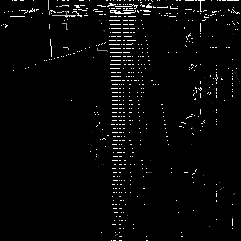

In [50]:
rs[3].show()

{'token': 'a183049901c24361a6b0b11b8013137c', 'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567', 'translation': [0.943713, 0.0, 1.84023], 'rotation': [0.7077955119163518, -0.006492242056004365, 0.010646214713995808, -0.7063073142877817], 'camera_intrinsic': []}


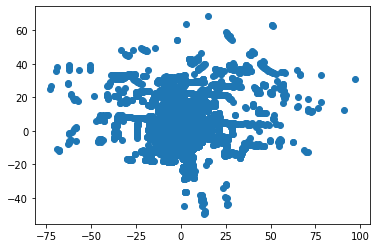

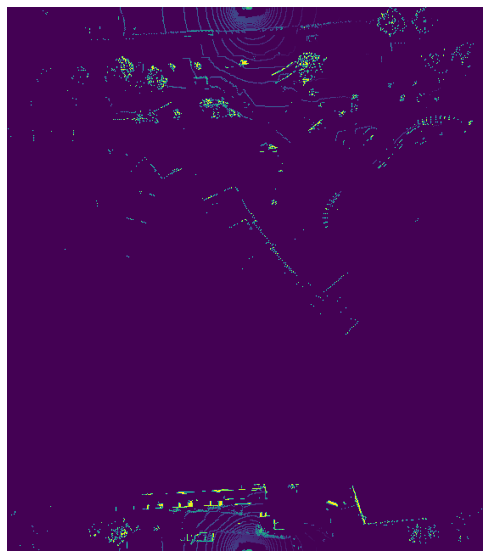

In [111]:
!export LIBGL_ALWAYS_INDIRECT=1

from open3d import geometry, utility, visualization
from matplotlib import pyplot as plt
import struct
import numpy as np

from pyquaternion import Quaternion

size_float = 4
list_pcd = []

sample_token = nusc.get('sample', nusc.scene[0]['first_sample_token'])
data_sample_token = nusc.get('sample_data', sample_token['data']['LIDAR_TOP'])
calb = nusc.get('calibrated_sensor', data_sample_token['calibrated_sensor_token'])
print(calb)

# sample_data_token = "94368c083c674f7a84c7273854bfc7ac"
bin_path = data_sample_token['filename']

with open('/mnt/d/tmp/nu_scene/data/sets/nuscenes/' + bin_path, "rb") as f:
    byte = f.read(size_float * 5)
    while byte:
        x, y, z, _, _ = struct.unpack("fffff", byte)
        list_pcd.append([x, y, z])
        byte = f.read(size_float * 5)

np_pcd = np.asarray(list_pcd)

def rotate(d, rot_matrix: np.ndarray):
    return np.dot(d, rot_matrix)

def translate(d, x: np.ndarray):
    for i in range(3):
        d[:, i] += x[i]

    return d

np_pcd = rotate(np_pcd, Quaternion(calb['rotation']).rotation_matrix)
np_pcd = translate(np_pcd, np.array(calb['translation']))


h_filter = (np_pcd[:, 2] < 3)
plt.scatter(np_pcd[h_filter][:, 0], np_pcd[h_filter][:, 1])

# pcd = geometry.PointCloud()
# pcd.points = utility.Vector3dVector(np_pcd)
# down_pcd = pcd.voxel_down_sample(voxel_size=0.5)

# visualization.draw_geometries([pcd])

RANGE       = 140

RIGHT_MOST  = RANGE/2
LEFT_MOST   = -1 * RANGE/2

BACK_MOST   = -20
FORE_MOST   = RANGE

BOTT_MOST   = -0.5
TOP_MOST    = 2.5

# Define a square range of left, right, back, front
side_range = (LEFT_MOST, RIGHT_MOST) 
fwd_range = (BACK_MOST, FORE_MOST)
height_range = (BOTT_MOST, TOP_MOST)

# Filter the points in the square range only
def extract_col(d):
    x_points = d[:, 0]
    y_points = d[:, 1]
    z_points = d[:, 2]

    return x_points, y_points, z_points

x_points, y_points, z_points = extract_col(np_pcd)

cond_side   = (x_points >= side_range[0]) & (x_points <= side_range[1])
cond_fwd    = (y_points >= fwd_range[0]) & (y_points <= fwd_range[1])

    # Do filter
np_pcd = np_pcd[cond_side & cond_fwd]
x_points, y_points, z_points = extract_col(np_pcd)

# Convert original coord to new pixel coord (INT) accord. to resolution
RES = 0.25

def round_pixel(d):
    return (d/RES).astype(np.int32)

x_img = round_pixel(x_points) + int(np.ceil(side_range[1]/RES))
y_img = round_pixel(y_points)

def scale_to_255(d, v_min, v_max):
    return (((d - v_min) / float(v_max - v_min)) * 255).astype(np.uint8)

pixel_values = np.clip(z_points, a_min = height_range[0], a_max = height_range[1])
pixel_values = scale_to_255(pixel_values, height_range[0], height_range[1])

h_img = 1 + int((fwd_range[1] - fwd_range[0])/RES)
w_img = 1 + int((side_range[1] - side_range[0])/RES)
im = np.zeros((h_img, w_img), dtype=np.uint8)

im[y_img, x_img] = pixel_values

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.imshow(im)
axes.set_axis_off()

plt.show()
